In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install flair==0.12.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.1/373.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.5/788.5 kB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 22.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 85.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 121.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79

In [3]:
!pip install transformers==4.30.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.0
    Uninstalling tokenizers-0.15.0:
      Successfully uninstalled tokenizers-0.15.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


In [4]:
from flair.data import Corpus
from flair.datasets import ColumnCorpus
from flair.embeddings import TokenEmbeddings, WordEmbeddings, StackedEmbeddings, FlairEmbeddings, FastTextEmbeddings
from typing import List

In [12]:
# French corpus of 32 texts from ECHR (automatic and official translations with manual annotations)

columns = {0:'text', 1:'ner'}

corpus_folder = '/content/drive/MyDrive/.../'
corpus : Corpus = ColumnCorpus(corpus_folder, columns,
                                    train_file='FR-manual.tsv', column_delimiter=' ',
                                    dev_file=None,
                                    test_file=None
)

# obtain and print corpus statistics
stats = corpus.obtain_statistics()
print(stats)

2023-11-23 13:48:53,707 Reading data from /content/drive/MyDrive/HAPLAPMaster/HAPLAPThesis/Seq-labeler
2023-11-23 13:48:53,708 Train: /content/drive/MyDrive/HAPLAPMaster/HAPLAPThesis/Seq-labeler/FR-manual-PER.tsv
2023-11-23 13:48:53,709 Dev: None
2023-11-23 13:48:53,710 Test: None
{
    "TRAIN": {
        "dataset": "TRAIN",
        "total_number_of_documents": 1308,
        "number_of_documents_per_class": {
            "CODE": 68,
            "LOC": 239,
            "PER": 196,
            "DATE": 545,
            "TIME": 12,
            "QUANTITY": 151,
            "ORG": 114,
            "NATIONALITY": 75,
            "LEGAL_PROFESSIONAL": 274,
            "ETHNIC_CATEGORY": 12,
            "CURRENCY": 13,
            "null": 1
        },
        "number_of_tokens_per_tag": {},
        "number_of_tokens": {
            "total": 38363,
            "min": 1,
            "max": 508,
            "avg": 29.329510703363916
        }
    },
    "TEST": {
        "dataset": "TEST",
       

In [13]:
# 2. what tag do we want to predict?
tag_type = 'ner'

# 3. make the tag dictionary from the corpus
new_tag_dictionary = corpus.make_label_dictionary(label_type=tag_type)
print(new_tag_dictionary.idx2item)

2023-11-23 13:49:07,815 Computing label dictionary. Progress:


1308it [00:00, 52771.23it/s]

2023-11-23 13:49:07,844 Dictionary created for label 'ner' with 13 values: DATE (seen 545 times), LEGAL_PROFESSIONAL (seen 274 times), LOC (seen 239 times), PER (seen 196 times), QUANTITY (seen 151 times), ORG (seen 114 times), NATIONALITY (seen 75 times), CODE (seen 68 times), CURRENCY (seen 13 times), TIME (seen 12 times), ETHNIC_CATEGORY (seen 12 times), null (seen 1 times)
[b'<unk>', b'DATE', b'LEGAL_PROFESSIONAL', b'LOC', b'PER', b'QUANTITY', b'ORG', b'NATIONALITY', b'CODE', b'CURRENCY', b'TIME', b'ETHNIC_CATEGORY', b'null']


In [14]:
# initialize sequence tagger
from flair.models import SequenceTagger

tagger = SequenceTagger.load("flair/ner-french")

2023-11-23 13:49:12,832 SequenceTagger predicts: Dictionary with 19 tags: O, S-LOC, B-LOC, E-LOC, I-LOC, S-PER, B-PER, E-PER, I-PER, S-MISC, B-MISC, E-MISC, I-MISC, S-ORG, B-ORG, E-ORG, I-ORG, <START>, <STOP>


In [15]:
new_tagger = SequenceTagger(tagger.embeddings, new_tag_dictionary, tag_type=tag_type)

2023-11-23 13:49:15,647 SequenceTagger predicts: Dictionary with 49 tags: O, S-DATE, B-DATE, E-DATE, I-DATE, S-LEGAL_PROFESSIONAL, B-LEGAL_PROFESSIONAL, E-LEGAL_PROFESSIONAL, I-LEGAL_PROFESSIONAL, S-LOC, B-LOC, E-LOC, I-LOC, S-PER, B-PER, E-PER, I-PER, S-QUANTITY, B-QUANTITY, E-QUANTITY, I-QUANTITY, S-ORG, B-ORG, E-ORG, I-ORG, S-NATIONALITY, B-NATIONALITY, E-NATIONALITY, I-NATIONALITY, S-CODE, B-CODE, E-CODE, I-CODE, S-CURRENCY, B-CURRENCY, E-CURRENCY, I-CURRENCY, S-TIME, B-TIME, E-TIME, I-TIME, S-ETHNIC_CATEGORY, B-ETHNIC_CATEGORY, E-ETHNIC_CATEGORY, I-ETHNIC_CATEGORY, S-null, B-null, E-null, I-null


In [16]:
# initialize trainer
from flair.trainers import ModelTrainer
trainer = ModelTrainer(new_tagger, corpus)

In [17]:
# train # train_with_dev=True
trainer.train('/content/drive/MyDrive/...',
              learning_rate=0.1,
              mini_batch_size=32,
              max_epochs=17,
              write_weights=True)
# saving the model into your drive (need to provide the full path of the folder in which you want to save the model)

2023-11-23 13:49:22,260 ----------------------------------------------------------------------------------------------------
2023-11-23 13:49:22,261 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      '0-/vol/home-vol2/ml/akbikala/.flair/embeddings/fr-wiki-fasttext-300d-1M'
      (embedding): Embedding(1000000, 300)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.5, inplace=False)
        (encoder): Embedding(275, 100)
        (rnn): LSTM(100, 1024)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.5, inplace=False)
        (encoder): Embedding(275, 100)
        (rnn): LSTM(100, 1024)
      )
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=2348, out_features=2348, bias=True)
  (rnn): LSTM(2348, 256, batch_first=True, bidirectional=True)
  (linea

100%|██████████| 5/5 [00:01<00:00,  3.84it/s]

2023-11-23 13:49:39,204 Evaluating as a multi-label problem: False


2023-11-23 13:49:39,223 DEV : loss 0.48874086141586304 - f1-score (micro avg)  0.24
2023-11-23 13:49:39,243 BAD EPOCHS (no improvement): 0
2023-11-23 13:49:39,247 saving best model
2023-11-23 13:49:42,727 ----------------------------------------------------------------------------------------------------
2023-11-23 13:49:43,360 epoch 2 - iter 4/41 - loss 0.42283308 - time (sec): 0.61 - samples/sec: 6223.89 - lr: 0.100000
2023-11-23 13:49:47,311 epoch 2 - iter 8/41 - loss 0.55044071 - time (sec): 4.56 - samples/sec: 1747.36 - lr: 0.100000
2023-11-23 13:49:48,358 epoch 2 - iter 12/41 - loss 0.48820491 - time (sec): 5.61 - samples/sec: 2127.03 - lr: 0.100000
2023-11-23 13:49:49,416 epoch 2 - iter 16/41 - loss 0.49050990 - time (sec): 6.66 - samples/sec: 2261.52 - lr: 0.100000
2023-11-23 13:49:50,580 epoch 2 - iter 20/41 - loss 0.46927550 - time (sec): 7.83 - samples/sec: 2391.56 - lr: 0.100000
2023-11-23 13:49:51,728 epoch 2 - iter 24/41 - loss 0.45139454 - time (sec): 8.98 - samples/sec:

100%|██████████| 5/5 [00:01<00:00,  3.75it/s]

2023-11-23 13:49:58,670 Evaluating as a multi-label problem: False
2023-11-23 13:49:58,690 DEV : loss 0.3318840563297272 - f1-score (micro avg)  0.3166


2023-11-23 13:49:58,711 BAD EPOCHS (no improvement): 0
2023-11-23 13:49:58,726 saving best model
2023-11-23 13:50:03,060 ----------------------------------------------------------------------------------------------------
2023-11-23 13:50:03,761 epoch 3 - iter 4/41 - loss 0.34082300 - time (sec): 0.68 - samples/sec: 5646.55 - lr: 0.100000
2023-11-23 13:50:06,348 epoch 3 - iter 8/41 - loss 0.31763700 - time (sec): 3.26 - samples/sec: 2242.30 - lr: 0.100000
2023-11-23 13:50:07,476 epoch 3 - iter 12/41 - loss 0.29906878 - time (sec): 4.39 - samples/sec: 2426.23 - lr: 0.100000
2023-11-23 13:50:08,588 epoch 3 - iter 16/41 - loss 0.30538347 - time (sec): 5.50 - samples/sec: 2633.44 - lr: 0.100000
2023-11-23 13:50:09,671 epoch 3 - iter 20/41 - loss 0.29879753 - time (sec): 6.59 - samples/sec: 2733.47 - lr: 0.100000
2023-11-23 13:50:10,982 epoch 3 - iter 24/41 - loss 0.31034194 - time (sec): 7.90 - samples/sec: 2764.29 - lr: 0.100000
2023-11-23 13:50:12,298 epoch 3 - iter 28/41 - loss 0.309583

100%|██████████| 5/5 [00:01<00:00,  4.37it/s]

2023-11-23 13:50:18,394 Evaluating as a multi-label problem: False
2023-11-23 13:50:18,407 DEV : loss 0.23881015181541443 - f1-score (micro avg)  0.4299
2023-11-23 13:50:18,425 BAD EPOCHS (no improvement): 0
2023-11-23 13:50:18,428 saving best model


2023-11-23 13:50:22,218 ----------------------------------------------------------------------------------------------------
2023-11-23 13:50:23,599 epoch 4 - iter 4/41 - loss 0.39359642 - time (sec): 1.38 - samples/sec: 2961.13 - lr: 0.100000
2023-11-23 13:50:25,826 epoch 4 - iter 8/41 - loss 0.32103880 - time (sec): 3.61 - samples/sec: 2132.82 - lr: 0.100000
2023-11-23 13:50:26,987 epoch 4 - iter 12/41 - loss 0.27645812 - time (sec): 4.77 - samples/sec: 2473.89 - lr: 0.100000
2023-11-23 13:50:28,169 epoch 4 - iter 16/41 - loss 0.25916569 - time (sec): 5.95 - samples/sec: 2568.69 - lr: 0.100000
2023-11-23 13:50:29,471 epoch 4 - iter 20/41 - loss 0.25994213 - time (sec): 7.25 - samples/sec: 2654.57 - lr: 0.100000
2023-11-23 13:50:30,699 epoch 4 - iter 24/41 - loss 0.24511218 - time (sec): 8.48 - samples/sec: 2691.28 - lr: 0.100000
2023-11-23 13:50:31,880 epoch 4 - iter 28/41 - loss 0.23911544 - time (sec): 9.66 - samples/sec: 2746.54 - lr: 0.100000
2023-11-23 13:50:33,130 epoch 4 - ite

100%|██████████| 5/5 [00:01<00:00,  2.81it/s]

2023-11-23 13:50:37,862 Evaluating as a multi-label problem: False
2023-11-23 13:50:37,875 DEV : loss 0.1781695932149887 - f1-score (micro avg)  0.6094
2023-11-23 13:50:37,892 BAD EPOCHS (no improvement): 0
2023-11-23 13:50:37,895 saving best model


2023-11-23 13:50:42,377 ----------------------------------------------------------------------------------------------------
2023-11-23 13:50:43,827 epoch 5 - iter 4/41 - loss 0.37390090 - time (sec): 1.45 - samples/sec: 3061.71 - lr: 0.100000
2023-11-23 13:50:46,483 epoch 5 - iter 8/41 - loss 0.27787537 - time (sec): 4.10 - samples/sec: 2003.90 - lr: 0.100000
2023-11-23 13:50:47,544 epoch 5 - iter 12/41 - loss 0.23011157 - time (sec): 5.16 - samples/sec: 2262.25 - lr: 0.100000
2023-11-23 13:50:48,750 epoch 5 - iter 16/41 - loss 0.22237480 - time (sec): 6.37 - samples/sec: 2453.12 - lr: 0.100000
2023-11-23 13:50:49,827 epoch 5 - iter 20/41 - loss 0.22434086 - time (sec): 7.45 - samples/sec: 2593.44 - lr: 0.100000
2023-11-23 13:50:50,913 epoch 5 - iter 24/41 - loss 0.21637995 - time (sec): 8.53 - samples/sec: 2671.20 - lr: 0.100000
2023-11-23 13:50:51,963 epoch 5 - iter 28/41 - loss 0.21481957 - time (sec): 9.58 - samples/sec: 2756.23 - lr: 0.100000
2023-11-23 13:50:53,038 epoch 5 - ite

100%|██████████| 5/5 [00:01<00:00,  3.96it/s]

2023-11-23 13:50:57,409 Evaluating as a multi-label problem: False
2023-11-23 13:50:57,423 DEV : loss 0.14401447772979736 - f1-score (micro avg)  0.6561


2023-11-23 13:50:57,440 BAD EPOCHS (no improvement): 0
2023-11-23 13:50:57,444 saving best model
2023-11-23 13:51:01,375 ----------------------------------------------------------------------------------------------------
2023-11-23 13:51:02,066 epoch 6 - iter 4/41 - loss 0.15156974 - time (sec): 0.66 - samples/sec: 5806.66 - lr: 0.100000
2023-11-23 13:51:04,641 epoch 6 - iter 8/41 - loss 0.16310892 - time (sec): 3.24 - samples/sec: 2321.68 - lr: 0.100000
2023-11-23 13:51:05,767 epoch 6 - iter 12/41 - loss 0.15194415 - time (sec): 4.36 - samples/sec: 2567.31 - lr: 0.100000
2023-11-23 13:51:06,871 epoch 6 - iter 16/41 - loss 0.15619782 - time (sec): 5.47 - samples/sec: 2693.27 - lr: 0.100000
2023-11-23 13:51:08,046 epoch 6 - iter 20/41 - loss 0.15447749 - time (sec): 6.64 - samples/sec: 2773.73 - lr: 0.100000
2023-11-23 13:51:09,268 epoch 6 - iter 24/41 - loss 0.15302357 - time (sec): 7.87 - samples/sec: 2814.15 - lr: 0.100000
2023-11-23 13:51:10,438 epoch 6 - iter 28/41 - loss 0.145408

100%|██████████| 5/5 [00:01<00:00,  4.18it/s]

2023-11-23 13:51:16,886 Evaluating as a multi-label problem: False
2023-11-23 13:51:16,899 DEV : loss 0.13161344826221466 - f1-score (micro avg)  0.6602
2023-11-23 13:51:16,916 BAD EPOCHS (no improvement): 0
2023-11-23 13:51:16,920 saving best model


2023-11-23 13:51:20,813 ----------------------------------------------------------------------------------------------------
2023-11-23 13:51:21,461 epoch 7 - iter 4/41 - loss 0.09325646 - time (sec): 0.65 - samples/sec: 6041.51 - lr: 0.100000
2023-11-23 13:51:24,333 epoch 7 - iter 8/41 - loss 0.11392290 - time (sec): 3.52 - samples/sec: 2128.54 - lr: 0.100000
2023-11-23 13:51:25,569 epoch 7 - iter 12/41 - loss 0.11202385 - time (sec): 4.75 - samples/sec: 2372.18 - lr: 0.100000
2023-11-23 13:51:26,713 epoch 7 - iter 16/41 - loss 0.11570405 - time (sec): 5.90 - samples/sec: 2541.11 - lr: 0.100000
2023-11-23 13:51:28,017 epoch 7 - iter 20/41 - loss 0.12595445 - time (sec): 7.20 - samples/sec: 2600.73 - lr: 0.100000
2023-11-23 13:51:29,154 epoch 7 - iter 24/41 - loss 0.12416925 - time (sec): 8.34 - samples/sec: 2666.27 - lr: 0.100000
2023-11-23 13:51:30,466 epoch 7 - iter 28/41 - loss 0.12309020 - time (sec): 9.65 - samples/sec: 2674.17 - lr: 0.100000
2023-11-23 13:51:31,836 epoch 7 - ite

100%|██████████| 5/5 [00:01<00:00,  4.20it/s]

2023-11-23 13:51:36,831 Evaluating as a multi-label problem: False
2023-11-23 13:51:36,845 DEV : loss 0.11047980189323425 - f1-score (micro avg)  0.7089
2023-11-23 13:51:36,861 BAD EPOCHS (no improvement): 0
2023-11-23 13:51:36,865 saving best model


2023-11-23 13:51:40,619 ----------------------------------------------------------------------------------------------------
2023-11-23 13:51:41,264 epoch 8 - iter 4/41 - loss 0.09832367 - time (sec): 0.64 - samples/sec: 5680.10 - lr: 0.100000
2023-11-23 13:51:45,115 epoch 8 - iter 8/41 - loss 0.20879517 - time (sec): 4.49 - samples/sec: 1784.68 - lr: 0.100000
2023-11-23 13:51:46,397 epoch 8 - iter 12/41 - loss 0.18619603 - time (sec): 5.78 - samples/sec: 2115.38 - lr: 0.100000
2023-11-23 13:51:47,619 epoch 8 - iter 16/41 - loss 0.16824834 - time (sec): 7.00 - samples/sec: 2238.98 - lr: 0.100000
2023-11-23 13:51:48,724 epoch 8 - iter 20/41 - loss 0.15273060 - time (sec): 8.10 - samples/sec: 2417.67 - lr: 0.100000
2023-11-23 13:51:50,079 epoch 8 - iter 24/41 - loss 0.14472672 - time (sec): 9.46 - samples/sec: 2479.87 - lr: 0.100000
2023-11-23 13:51:51,280 epoch 8 - iter 28/41 - loss 0.14016965 - time (sec): 10.66 - samples/sec: 2517.36 - lr: 0.100000
2023-11-23 13:51:52,362 epoch 8 - it

100%|██████████| 5/5 [00:01<00:00,  4.14it/s]

2023-11-23 13:51:56,557 Evaluating as a multi-label problem: False
2023-11-23 13:51:56,572 DEV : loss 0.09682486951351166 - f1-score (micro avg)  0.7273


2023-11-23 13:51:56,591 BAD EPOCHS (no improvement): 0
2023-11-23 13:51:56,595 saving best model
2023-11-23 13:52:00,840 ----------------------------------------------------------------------------------------------------
2023-11-23 13:52:01,589 epoch 9 - iter 4/41 - loss 0.11769788 - time (sec): 0.75 - samples/sec: 5413.26 - lr: 0.100000
2023-11-23 13:52:03,726 epoch 9 - iter 8/41 - loss 0.10547598 - time (sec): 2.88 - samples/sec: 2764.78 - lr: 0.100000
2023-11-23 13:52:04,774 epoch 9 - iter 12/41 - loss 0.13382809 - time (sec): 3.93 - samples/sec: 2873.44 - lr: 0.100000
2023-11-23 13:52:05,870 epoch 9 - iter 16/41 - loss 0.11955557 - time (sec): 5.03 - samples/sec: 2957.51 - lr: 0.100000
2023-11-23 13:52:07,771 epoch 9 - iter 20/41 - loss 0.13947385 - time (sec): 6.93 - samples/sec: 2696.13 - lr: 0.100000
2023-11-23 13:52:09,251 epoch 9 - iter 24/41 - loss 0.12962723 - time (sec): 8.41 - samples/sec: 2635.70 - lr: 0.100000
2023-11-23 13:52:10,588 epoch 9 - iter 28/41 - loss 0.126177

100%|██████████| 5/5 [00:01<00:00,  3.50it/s]

2023-11-23 13:52:16,354 Evaluating as a multi-label problem: False
2023-11-23 13:52:16,368 DEV : loss 0.09673892706632614 - f1-score (micro avg)  0.788
2023-11-23 13:52:16,387 BAD EPOCHS (no improvement): 0
2023-11-23 13:52:16,391 saving best model


2023-11-23 13:52:20,198 ----------------------------------------------------------------------------------------------------
2023-11-23 13:52:21,317 epoch 10 - iter 4/41 - loss 0.08045071 - time (sec): 1.12 - samples/sec: 3326.88 - lr: 0.100000
2023-11-23 13:52:23,890 epoch 10 - iter 8/41 - loss 0.07340111 - time (sec): 3.69 - samples/sec: 2010.27 - lr: 0.100000
2023-11-23 13:52:24,994 epoch 10 - iter 12/41 - loss 0.07535629 - time (sec): 4.79 - samples/sec: 2289.39 - lr: 0.100000
2023-11-23 13:52:26,107 epoch 10 - iter 16/41 - loss 0.07852838 - time (sec): 5.91 - samples/sec: 2449.10 - lr: 0.100000
2023-11-23 13:52:27,324 epoch 10 - iter 20/41 - loss 0.08327031 - time (sec): 7.12 - samples/sec: 2540.51 - lr: 0.100000
2023-11-23 13:52:28,602 epoch 10 - iter 24/41 - loss 0.08602540 - time (sec): 8.40 - samples/sec: 2647.46 - lr: 0.100000
2023-11-23 13:52:30,635 epoch 10 - iter 28/41 - loss 0.09927983 - time (sec): 10.43 - samples/sec: 2553.41 - lr: 0.100000
2023-11-23 13:52:31,921 epoch

100%|██████████| 5/5 [00:01<00:00,  4.30it/s]

2023-11-23 13:52:36,161 Evaluating as a multi-label problem: False
2023-11-23 13:52:36,176 DEV : loss 0.087374746799469 - f1-score (micro avg)  0.7807
2023-11-23 13:52:36,195 BAD EPOCHS (no improvement): 1
2023-11-23 13:52:36,200 ----------------------------------------------------------------------------------------------------


2023-11-23 13:52:36,798 epoch 11 - iter 4/41 - loss 0.08085245 - time (sec): 0.60 - samples/sec: 5747.24 - lr: 0.100000
2023-11-23 13:52:38,788 epoch 11 - iter 8/41 - loss 0.11368540 - time (sec): 2.59 - samples/sec: 3011.57 - lr: 0.100000
2023-11-23 13:52:39,982 epoch 11 - iter 12/41 - loss 0.10344807 - time (sec): 3.78 - samples/sec: 3057.19 - lr: 0.100000
2023-11-23 13:52:41,173 epoch 11 - iter 16/41 - loss 0.09660541 - time (sec): 4.97 - samples/sec: 3072.02 - lr: 0.100000
2023-11-23 13:52:42,444 epoch 11 - iter 20/41 - loss 0.10810653 - time (sec): 6.24 - samples/sec: 3063.96 - lr: 0.100000
2023-11-23 13:52:43,632 epoch 11 - iter 24/41 - loss 0.10427943 - time (sec): 7.43 - samples/sec: 3082.44 - lr: 0.100000
2023-11-23 13:52:44,827 epoch 11 - iter 28/41 - loss 0.10546223 - time (sec): 8.63 - samples/sec: 3098.37 - lr: 0.100000
2023-11-23 13:52:45,990 epoch 11 - iter 32/41 - loss 0.10274049 - time (sec): 9.79 - samples/sec: 3090.12 - lr: 0.100000
2023-11-23 13:52:47,128 epoch 11 -

100%|██████████| 5/5 [00:01<00:00,  4.14it/s]

2023-11-23 13:52:50,212 Evaluating as a multi-label problem: False
2023-11-23 13:52:50,225 DEV : loss 0.07805139571428299 - f1-score (micro avg)  0.7637
2023-11-23 13:52:50,243 BAD EPOCHS (no improvement): 2
2023-11-23 13:52:50,247 ----------------------------------------------------------------------------------------------------


2023-11-23 13:52:51,752 epoch 12 - iter 4/41 - loss 0.15754568 - time (sec): 1.50 - samples/sec: 3042.05 - lr: 0.100000
2023-11-23 13:52:53,034 epoch 12 - iter 8/41 - loss 0.12469595 - time (sec): 2.79 - samples/sec: 2939.66 - lr: 0.100000
2023-11-23 13:52:54,227 epoch 12 - iter 12/41 - loss 0.11056605 - time (sec): 3.98 - samples/sec: 2967.25 - lr: 0.100000
2023-11-23 13:52:55,429 epoch 12 - iter 16/41 - loss 0.10060429 - time (sec): 5.18 - samples/sec: 3019.05 - lr: 0.100000
2023-11-23 13:52:56,526 epoch 12 - iter 20/41 - loss 0.09738300 - time (sec): 6.28 - samples/sec: 3058.00 - lr: 0.100000
2023-11-23 13:52:57,679 epoch 12 - iter 24/41 - loss 0.09434436 - time (sec): 7.43 - samples/sec: 3091.20 - lr: 0.100000
2023-11-23 13:52:58,786 epoch 12 - iter 28/41 - loss 0.10214772 - time (sec): 8.54 - samples/sec: 3094.56 - lr: 0.100000
2023-11-23 13:52:59,940 epoch 12 - iter 32/41 - loss 0.09939311 - time (sec): 9.69 - samples/sec: 3111.11 - lr: 0.100000
2023-11-23 13:53:01,031 epoch 12 -

100%|██████████| 5/5 [00:01<00:00,  4.17it/s]

2023-11-23 13:53:04,242 Evaluating as a multi-label problem: False
2023-11-23 13:53:04,255 DEV : loss 0.07440420985221863 - f1-score (micro avg)  0.7801
2023-11-23 13:53:04,273 BAD EPOCHS (no improvement): 3
2023-11-23 13:53:04,277 ----------------------------------------------------------------------------------------------------


2023-11-23 13:53:04,874 epoch 13 - iter 4/41 - loss 0.07970682 - time (sec): 0.60 - samples/sec: 6081.63 - lr: 0.100000
2023-11-23 13:53:05,986 epoch 13 - iter 8/41 - loss 0.08836365 - time (sec): 1.71 - samples/sec: 4402.61 - lr: 0.100000
2023-11-23 13:53:07,141 epoch 13 - iter 12/41 - loss 0.10291783 - time (sec): 2.86 - samples/sec: 4040.50 - lr: 0.100000
2023-11-23 13:53:08,994 epoch 13 - iter 16/41 - loss 0.11612433 - time (sec): 4.72 - samples/sec: 3285.46 - lr: 0.100000
2023-11-23 13:53:10,162 epoch 13 - iter 20/41 - loss 0.10350113 - time (sec): 5.88 - samples/sec: 3263.09 - lr: 0.100000
2023-11-23 13:53:11,272 epoch 13 - iter 24/41 - loss 0.10064010 - time (sec): 6.99 - samples/sec: 3300.25 - lr: 0.100000
2023-11-23 13:53:12,442 epoch 13 - iter 28/41 - loss 0.10129700 - time (sec): 8.16 - samples/sec: 3277.99 - lr: 0.100000
2023-11-23 13:53:13,577 epoch 13 - iter 32/41 - loss 0.09744020 - time (sec): 9.30 - samples/sec: 3281.22 - lr: 0.100000
2023-11-23 13:53:14,629 epoch 13 -

100%|██████████| 5/5 [00:01<00:00,  4.24it/s]

2023-11-23 13:53:17,674 Evaluating as a multi-label problem: False
2023-11-23 13:53:17,688 DEV : loss 0.06688208132982254 - f1-score (micro avg)  0.8164
2023-11-23 13:53:17,705 BAD EPOCHS (no improvement): 0
2023-11-23 13:53:17,709 saving best model


2023-11-23 13:53:21,378 ----------------------------------------------------------------------------------------------------
2023-11-23 13:53:22,028 epoch 14 - iter 4/41 - loss 0.05957640 - time (sec): 0.65 - samples/sec: 5458.51 - lr: 0.100000
2023-11-23 13:53:25,058 epoch 14 - iter 8/41 - loss 0.06709788 - time (sec): 3.68 - samples/sec: 1919.10 - lr: 0.100000
2023-11-23 13:53:26,339 epoch 14 - iter 12/41 - loss 0.06853450 - time (sec): 4.96 - samples/sec: 2222.39 - lr: 0.100000
2023-11-23 13:53:27,534 epoch 14 - iter 16/41 - loss 0.06701649 - time (sec): 6.15 - samples/sec: 2408.68 - lr: 0.100000
2023-11-23 13:53:28,742 epoch 14 - iter 20/41 - loss 0.08009483 - time (sec): 7.36 - samples/sec: 2501.27 - lr: 0.100000
2023-11-23 13:53:30,726 epoch 14 - iter 24/41 - loss 0.09500918 - time (sec): 9.35 - samples/sec: 2403.22 - lr: 0.100000
2023-11-23 13:53:32,040 epoch 14 - iter 28/41 - loss 0.09437238 - time (sec): 10.66 - samples/sec: 2464.50 - lr: 0.100000
2023-11-23 13:53:33,364 epoch

100%|██████████| 5/5 [00:01<00:00,  3.63it/s]

2023-11-23 13:53:37,846 Evaluating as a multi-label problem: False
2023-11-23 13:53:37,860 DEV : loss 0.06159636750817299 - f1-score (micro avg)  0.8193
2023-11-23 13:53:37,880 BAD EPOCHS (no improvement): 0
2023-11-23 13:53:37,883 saving best model


2023-11-23 13:53:41,695 ----------------------------------------------------------------------------------------------------
2023-11-23 13:53:42,777 epoch 15 - iter 4/41 - loss 0.06246989 - time (sec): 1.08 - samples/sec: 3271.47 - lr: 0.100000
2023-11-23 13:53:45,370 epoch 15 - iter 8/41 - loss 0.06514283 - time (sec): 3.67 - samples/sec: 2000.81 - lr: 0.100000
2023-11-23 13:53:46,421 epoch 15 - iter 12/41 - loss 0.05785237 - time (sec): 4.72 - samples/sec: 2337.08 - lr: 0.100000
2023-11-23 13:53:47,661 epoch 15 - iter 16/41 - loss 0.05651212 - time (sec): 5.96 - samples/sec: 2478.43 - lr: 0.100000
2023-11-23 13:53:48,963 epoch 15 - iter 20/41 - loss 0.05609775 - time (sec): 7.27 - samples/sec: 2546.89 - lr: 0.100000
2023-11-23 13:53:50,106 epoch 15 - iter 24/41 - loss 0.06318452 - time (sec): 8.41 - samples/sec: 2633.63 - lr: 0.100000
2023-11-23 13:53:51,336 epoch 15 - iter 28/41 - loss 0.07398323 - time (sec): 9.64 - samples/sec: 2700.60 - lr: 0.100000
2023-11-23 13:53:53,232 epoch 

100%|██████████| 5/5 [00:01<00:00,  3.91it/s]

2023-11-23 13:53:57,582 Evaluating as a multi-label problem: False
2023-11-23 13:53:57,596 DEV : loss 0.06269174814224243 - f1-score (micro avg)  0.8421


2023-11-23 13:53:57,614 BAD EPOCHS (no improvement): 0
2023-11-23 13:53:57,618 saving best model
2023-11-23 13:54:01,321 ----------------------------------------------------------------------------------------------------
2023-11-23 13:54:01,940 epoch 16 - iter 4/41 - loss 0.06971184 - time (sec): 0.62 - samples/sec: 6033.15 - lr: 0.100000
2023-11-23 13:54:04,980 epoch 16 - iter 8/41 - loss 0.06558545 - time (sec): 3.66 - samples/sec: 1978.72 - lr: 0.100000
2023-11-23 13:54:06,047 epoch 16 - iter 12/41 - loss 0.06176928 - time (sec): 4.72 - samples/sec: 2274.32 - lr: 0.100000
2023-11-23 13:54:07,260 epoch 16 - iter 16/41 - loss 0.05466378 - time (sec): 5.94 - samples/sec: 2462.16 - lr: 0.100000
2023-11-23 13:54:09,268 epoch 16 - iter 20/41 - loss 0.07554973 - time (sec): 7.94 - samples/sec: 2346.69 - lr: 0.100000
2023-11-23 13:54:10,338 epoch 16 - iter 24/41 - loss 0.07364922 - time (sec): 9.01 - samples/sec: 2434.21 - lr: 0.100000
2023-11-23 13:54:11,566 epoch 16 - iter 28/41 - loss 0

100%|██████████| 5/5 [00:01<00:00,  3.93it/s]

2023-11-23 13:54:17,384 Evaluating as a multi-label problem: False
2023-11-23 13:54:17,398 DEV : loss 0.07488104701042175 - f1-score (micro avg)  0.8107


2023-11-23 13:54:17,418 BAD EPOCHS (no improvement): 1
2023-11-23 13:54:17,422 ----------------------------------------------------------------------------------------------------
2023-11-23 13:54:18,842 epoch 17 - iter 4/41 - loss 0.13751275 - time (sec): 1.42 - samples/sec: 2852.50 - lr: 0.100000
2023-11-23 13:54:20,143 epoch 17 - iter 8/41 - loss 0.09620724 - time (sec): 2.72 - samples/sec: 2790.68 - lr: 0.100000
2023-11-23 13:54:21,270 epoch 17 - iter 12/41 - loss 0.08024158 - time (sec): 3.85 - samples/sec: 2979.43 - lr: 0.100000
2023-11-23 13:54:22,360 epoch 17 - iter 16/41 - loss 0.07243051 - time (sec): 4.94 - samples/sec: 3022.75 - lr: 0.100000
2023-11-23 13:54:23,518 epoch 17 - iter 20/41 - loss 0.06708459 - time (sec): 6.09 - samples/sec: 3083.18 - lr: 0.100000
2023-11-23 13:54:24,674 epoch 17 - iter 24/41 - loss 0.06140924 - time (sec): 7.25 - samples/sec: 3099.74 - lr: 0.100000
2023-11-23 13:54:25,950 epoch 17 - iter 28/41 - loss 0.07119717 - time (sec): 8.53 - samples/sec

100%|██████████| 5/5 [00:01<00:00,  3.95it/s]

2023-11-23 13:54:31,364 Evaluating as a multi-label problem: False
2023-11-23 13:54:31,377 DEV : loss 0.057877037674188614 - f1-score (micro avg)  0.85
2023-11-23 13:54:31,394 BAD EPOCHS (no improvement): 0
2023-11-23 13:54:31,397 saving best model


2023-11-23 13:54:41,365 ----------------------------------------------------------------------------------------------------
2023-11-23 13:54:44,962 SequenceTagger predicts: Dictionary with 51 tags: O, S-DATE, B-DATE, E-DATE, I-DATE, S-LEGAL_PROFESSIONAL, B-LEGAL_PROFESSIONAL, E-LEGAL_PROFESSIONAL, I-LEGAL_PROFESSIONAL, S-LOC, B-LOC, E-LOC, I-LOC, S-PER, B-PER, E-PER, I-PER, S-QUANTITY, B-QUANTITY, E-QUANTITY, I-QUANTITY, S-ORG, B-ORG, E-ORG, I-ORG, S-NATIONALITY, B-NATIONALITY, E-NATIONALITY, I-NATIONALITY, S-CODE, B-CODE, E-CODE, I-CODE, S-CURRENCY, B-CURRENCY, E-CURRENCY, I-CURRENCY, S-TIME, B-TIME, E-TIME, I-TIME, S-ETHNIC_CATEGORY, B-ETHNIC_CATEGORY, E-ETHNIC_CATEGORY, I-ETHNIC_CATEGORY, S-null, B-null, E-null, I-null, <START>


100%|██████████| 6/6 [00:01<00:00,  5.86it/s]

2023-11-23 13:54:46,371 Evaluating as a multi-label problem: False
2023-11-23 13:54:46,385 0.8722	0.8441	0.8579	0.7659
2023-11-23 13:54:46,387 
Results:
- F-score (micro) 0.8579
- F-score (macro) 0.6284
- Accuracy 0.7659

By class:
                    precision    recall  f1-score   support

              DATE     0.9474    0.9153    0.9310        59
               LOC     0.8378    0.9394    0.8857        33
LEGAL_PROFESSIONAL     0.9259    1.0000    0.9615        25
               PER     1.0000    0.8571    0.9231        21
               ORG     0.7500    0.4000    0.5217        15
              CODE     0.8000    0.8000    0.8000        10
          QUANTITY     0.6000    0.6000    0.6000        10
       NATIONALITY     0.8000    1.0000    0.8889         8
          CURRENCY     0.3333    0.5000    0.4000         2
   ETHNIC_CATEGORY     0.0000    0.0000    0.0000         2
              TIME     0.0000    0.0000    0.0000         1

         micro avg     0.8722    0.8441    0.8

{'test_score': 0.8579234972677596,
 'dev_score_history': [0.24,
  0.3165829145728643,
  0.42986425339366513,
  0.6094420600858369,
  0.6561085972850679,
  0.6602409638554217,
  0.7088607594936709,
  0.7272727272727274,
  0.7880299251870324,
  0.7807228915662651,
  0.7637231503579952,
  0.7801418439716311,
  0.8164251207729469,
  0.8192771084337348,
  0.8421052631578947,
  0.8106796116504854,
  0.85],
 'train_loss_history': [0.9564077345847561,
  0.42524205706426116,
  0.3161967865969489,
  0.24146510136312985,
  0.1943161073984047,
  0.15743826601722363,
  0.14260612642715637,
  0.12924961113654432,
  0.11744563497461746,
  0.10743518840582071,
  0.09724334350073639,
  0.0951352815131116,
  0.09030149696647811,
  0.08612419315160441,
  0.07570560032616062,
  0.07398785277725282,
  0.07136250260667831],
 'dev_loss_history': [0.48874086141586304,
  0.3318840563297272,
  0.23881015181541443,
  0.1781695932149887,
  0.14401447772979736,
  0.13161344826221466,
  0.11047980189323425,
  0.096

2023-11-23 13:54:46,412 ----------------------------------------------------------------------------------------------------
2023-11-23 13:54:46,413 WARNING: No LOSS found for test split in this data.
2023-11-23 13:54:46,414 Are you sure you want to plot LOSS and not another value?
2023-11-23 13:54:46,414 ----------------------------------------------------------------------------------------------------
2023-11-23 13:54:46,449 ----------------------------------------------------------------------------------------------------
2023-11-23 13:54:46,450 WARNING: No F1 found for test split in this data.
2023-11-23 13:54:46,451 Are you sure you want to plot F1 and not another value?
2023-11-23 13:54:46,453 ----------------------------------------------------------------------------------------------------
2023-11-23 13:54:47,532 Loss and F1 plots are saved in /content/drive/MyDrive/HAPLAPMaster/HAPLAPThesis/Seq-labeler/Flair-FR/Flair-manual-FR/Flair-manual-model-FR-all/training.png


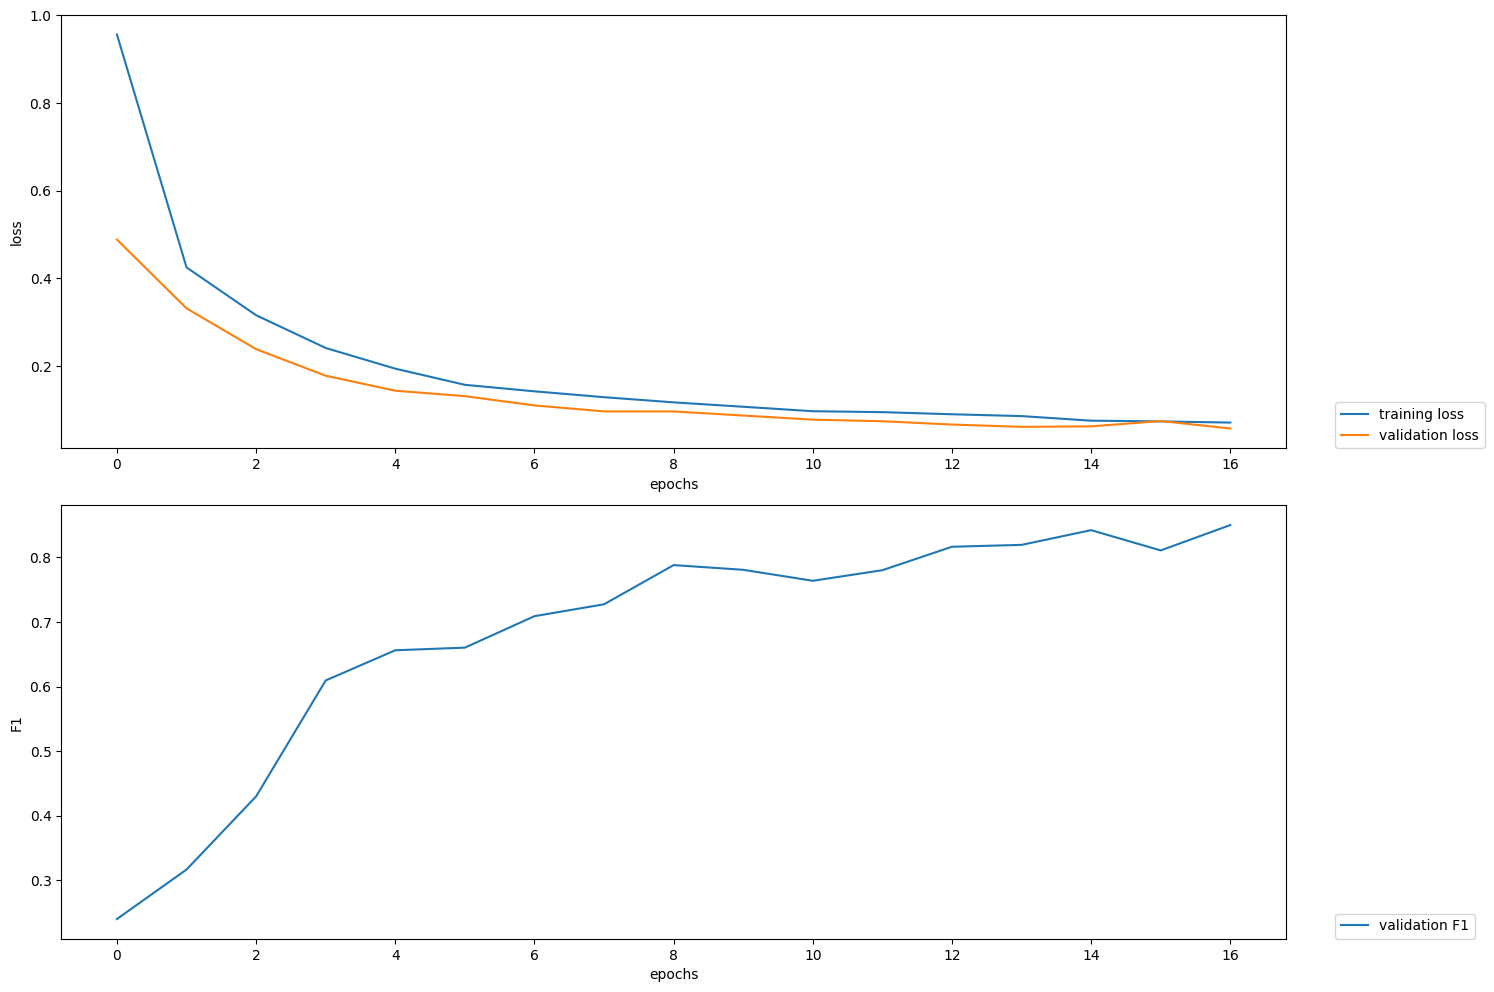

2023-11-23 13:54:50,683 Weights plots are saved in /content/drive/MyDrive/HAPLAPMaster/HAPLAPThesis/Seq-labeler/Flair-FR/Flair-manual-FR/Flair-manual-model-FR-all/weights.png


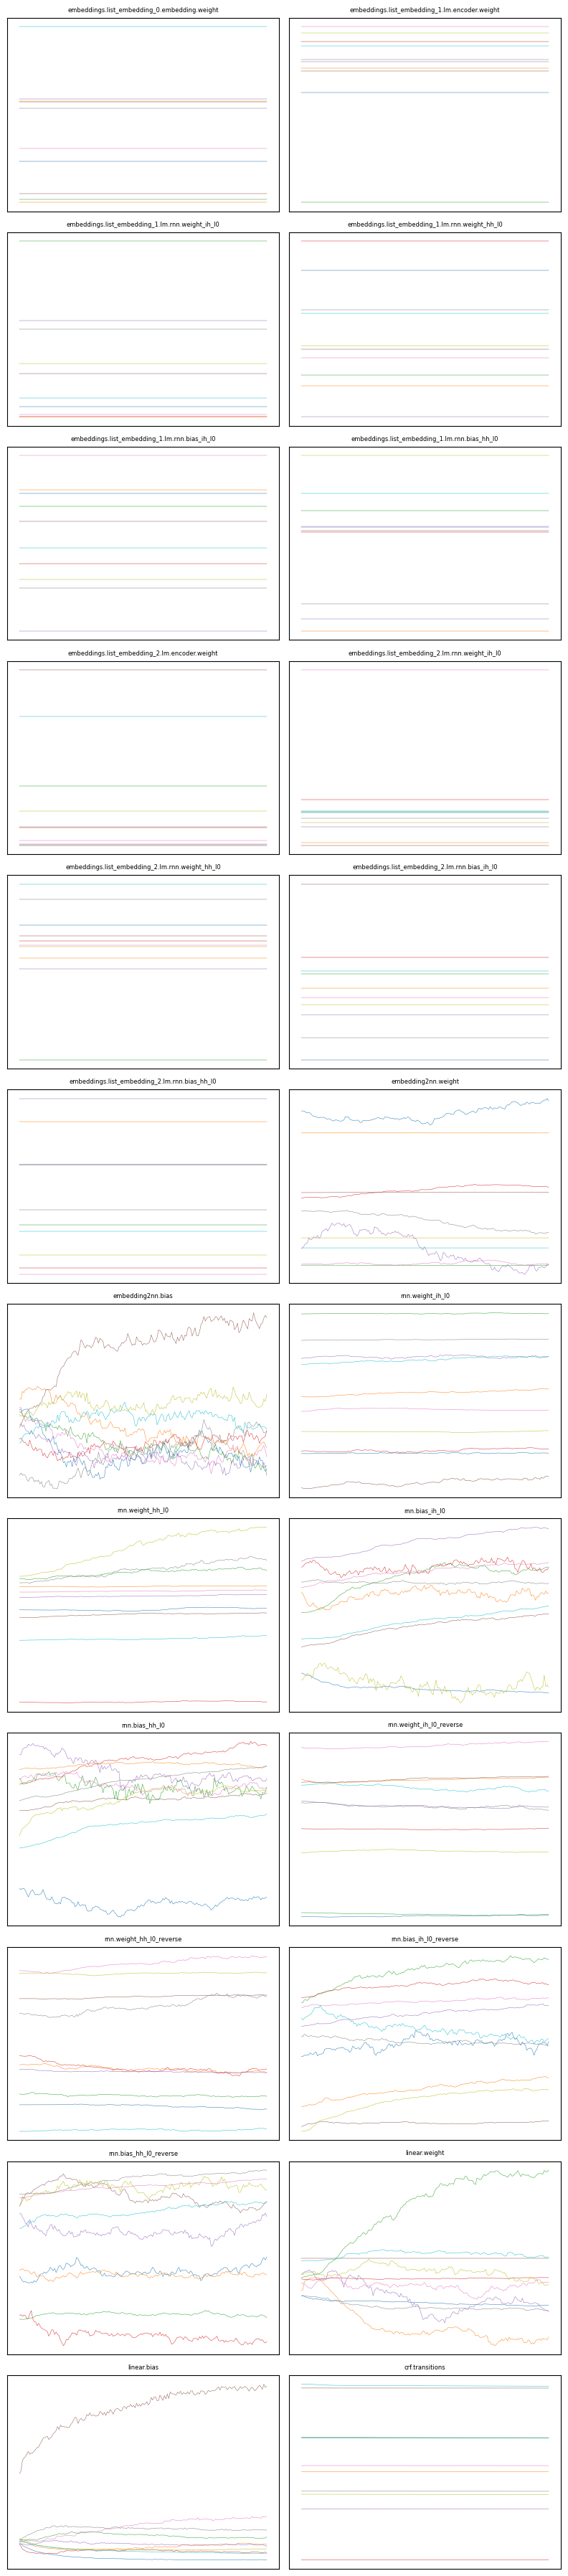

In [18]:
# plot training loss and weights
# Check documentation on training models with Flair

from flair.visual.training_curves import Plotter

plotter = Plotter()
plotter.plot_training_curves('/content/drive/MyDrive/.../loss.tsv')
plotter.plot_weights('/content/drive/MyDrive/.../weights.txt')